# Estimating RL parameters using PyMC

Modifying [this notebook](https://github.com/ricardoV94/stats/blob/master/modelling/RL_PyMC.ipynb) to simulate data and estimate parameters for the Machine Game.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import pandas as pd
import seaborn as sns
import scipy

import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az

## Data Generation Function

Initial data generation function uses an RL model with only two parameters $\alpha$ and $\beta$. Question for this notebook: can these parameters be recovered successfully by the different estimators (MLE vs. NUTS sampler).

In [2]:
def generate_data(alpha, beta, n=100, 
                  p_r={'high_var': [.95, .05], 'low_var': [.5,.5]},
                  rs = np.array(([5.0, -495.0],[-5.0, 495.0],[10.0, -100.0],[-10.0, 100.0])),
                  sQ = np.zeros((4, 2))
                 ):
    
    # Need to denote both machine type and action
    
    # Pre-specify machines for each trial in a randomly balanced manner
    if n%4 != 0:
        print("Number of trials is not divisable by 4.\nCreating trials for %s trials."%(str(n-(n%4))))
        n = n-(n%4)
    
    machs = np.array([0,1,2,3])
    machs = np.tile(machs, int(n/4))
    np.random.shuffle(machs)
    
    # Initialize empty array that will be populated in the loop based on Q values
    acts = np.zeros(n, dtype=np.int)
    
    # Generate by coin flip for machine with differing probabilities and outcomes
    rews = np.zeros(n, dtype=np.int)

    # Stores the expected value for each of 4 machines in each trial for each action
    Qs = np.zeros((n, 4, 2))

    # Initialize Q table
    # Denotes expected value of each action
    # Should look like [0, 0] for each machine
    # *** The expected value of not playing should not change from 0! ***
    # Could these initial expected values/beliefs also be estimated from data?
    # E.g. what if kids have more optimistic priors about each machine though they learn at the same rate
    Q = sQ.copy()
    
    for i in range(n):
        
        cur_machine = machs[i]
        
        # Apply the Softmax transformation
        exp_Q = np.exp(np.multiply(beta, Q[cur_machine]))
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice
        a = np.random.choice([0, 1], p=prob_a)
        
        # Simulate reward if machine is played
        if a == 1:
    
            # Before sampling reward determine which variance condition machine is in
            if cur_machine>1:
                cur_p = 'low_var'
            else:
                cur_p = 'high_var'

            # Sample reward for current machine given its reward probs and outcome options
            r = np.random.choice(rs[cur_machine], p = p_r[cur_p]) 
            
            # Update Q table only if the machine is played
            # And only the value of playing NOT of not playing
            Q[cur_machine][a] = Q[cur_machine][a] + alpha * (r - Q[cur_machine][a])
        
        # If the machine is not played then Q remains unchanged and no reward is received
        else:
            r = 0.0

        # Store values
        acts[i] = a
        rews[i] = r
        #Qs[i] = Q.copy()
        Qs[i] = Q

    return machs, acts, rews, Qs

## MLE likelihood functions

In [3]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    machines, actions, rewards = args

    # Initialize values
    Q = np.zeros((4, 2))
    log_prob_actions = np.zeros(len(actions))

    for t, (m, a, r) in enumerate(zip(machines, actions, rewards)):
        
        # Apply the softmax transformation
        Q_ = Q[m] * beta
        #print('t: %s, m: %s, a: %s, r: %s, Q:[%s, %s]'%(str(t), str(m), str(a), str(r), str(Q[m,0]), str(Q[m, 1])))
        log_prob_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        log_prob_actions[t] = log_prob_action[a]

        # Update the Q values for the next trial
        # Q[a] = Q[a] + alpha * (r - Q[a])
        Q[m][a] = Q[m][a] + alpha * (r - Q[m][a])

    # Return the negative log likelihood of all observed actions
    return -np.sum(log_prob_actions[1:])

In [4]:
def llik_td_vectorized(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    machines, actions, rewards = args
    n = len(actions)

    # Create a list with the Q values of each trial
    Qs = np.zeros((n, 4, 2), dtype=np.float)
    
    # The last Q values were never used, so there is no need to compute them
    for t, (m, a, r) in enumerate(zip(machines[:-1], actions[:-1], rewards[:-1])):
        Qs[t+1] = Qs[t]
        Qs[t+1, m, a] = Qs[t, m, a] + alpha * (r - Qs[t, m, a])
        Qs[t+1, m, 1-a] = Qs[t, m, 1-a]
        #print('t: %s, m: %s, a: %s, r: %s, Q:[%s, %s]'%(str(t), str(m), str(a), str(r), str(Qs[t,m,0]), str(Qs[t,m, 1])))

    # Apply the softmax transformation in a vectorized way
    idx = list(zip(range(n),machines))
    obs_Qs = [Qs[i] for i in idx]
    Qs_ = np.array(obs_Qs) * beta
    log_prob_actions = Qs_ - scipy.special.logsumexp(Qs_, axis=1)[:, None]

    # Return the log_prob_actions for the observed actions
    log_prob_obs_actions = log_prob_actions[np.arange(n), actions]
    return -np.sum(log_prob_obs_actions[1:]) 

## Generate fake data

In [5]:
true_alpha = .1
true_beta = 19
n = 120
machines, actions, rewards, all_Qs = generate_data(true_alpha, true_beta, n)

## Parameter recovery with MLE

In [7]:
x0 = [true_alpha, true_beta]
result = scipy.optimize.minimize(llik_td, x0, args=(machines, actions, rewards), method='BFGS')
print(result)
print('')
print(f'MLE: alpha = {result.x[0]:.2f} (true value = {true_alpha})')
print(f'MLE: beta = {result.x[1]:.2f} (true value = {true_beta})')

      fun: 4.8520302639231545
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([ 0.31334553, 19.00112236])

MLE: alpha = 0.31 (true value = 0.1)
MLE: beta = 19.00 (true value = 19)


### Compute true likelihood of data

In [8]:
llik_td([true_alpha, true_beta], *(machines, actions, rewards))

4.854275917356194

In [9]:
llik_td_vectorized([true_alpha, true_beta], *(machines, actions, rewards))

4.854275917356194

## Theano and pyMC3 functions

Calculating likelihood of data as an example of using theano tensors 

In [10]:
def update_Q(machine, action, reward,
             Q,
             alpha):
    Q = tt.set_subtensor(Q[machine, action], Q[machine, action] + alpha * (reward - Q[machine, action]))
    return Q

In [11]:
# Transform the variables into appropriate Theano objects
machines_ = theano.shared(np.asarray(machines, dtype='int16')) 
actions_ = theano.shared(np.asarray(actions, dtype='int16'))
rewards_ = theano.shared(np.asarray(rewards, dtype='int16'))

alpha = tt.scalar("alpha")
beta = tt.scalar("beta")

# Initialize the Q table
Qs = tt.zeros((4,2), dtype='float64')

# Compute the Q values for each trial
Qs, updates = theano.scan(
    fn=update_Q,
    sequences=[machines_, actions_, rewards_],
    outputs_info=[Qs],
    non_sequences=[alpha])

int_Qs = tt.zeros((1, 4,2), dtype='float64')

Qs = tt.concatenate((int_Qs, Qs), axis=0)

# Apply the softmax transformation
idx = list(zip(range(n),machines)) #list of tuples
obs_Qs = [Qs[tuple(i)] for i in idx]
Qs_ = obs_Qs * beta
log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

# Calculate the negative log likelihod of the observed actions
log_prob_actions = log_prob_actions[tt.arange(actions_.shape[0]), actions_]
neg_log_like = -tt.sum(log_prob_actions[1:])

In [12]:
theano_llik_td = theano.function(inputs=[alpha, beta], outputs=[neg_log_like], updates = updates)
result = theano_llik_td(true_alpha, true_beta)
float(result[0])

/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


4.854275917356196

### Theano likelihood calculator

Wrapped up likelihood calculation in function that can be called by pyMC model object

In [13]:
def theano_llik_td(alpha, beta, machines, actions, rewards, n=120):
    # Transform the variables into appropriate Theano objects
    machines_ = theano.shared(np.asarray(machines, dtype='int16')) 
    actions_ = theano.shared(np.asarray(actions, dtype='int16'))
    rewards_ = theano.shared(np.asarray(rewards, dtype='int16'))
    
    # Initialize the Q table
    Qs = tt.zeros((4,2), dtype='float64')

    # Compute the Q values for each trial
    Qs, updates = theano.scan(
        fn=update_Q,
        sequences=[machines_, actions_, rewards_],
        outputs_info=[Qs],
        non_sequences=[alpha])

    int_Qs = tt.zeros((1, 4,2), dtype='float64')

    Qs = tt.concatenate((int_Qs, Qs), axis=0)

    # Apply the softmax transformation
    idx = list(zip(range(n),machines)) #list of tuples
    obs_Qs = [Qs[i] for i in idx]
    Qs_ = obs_Qs * beta
    log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

    # Calculate the negative log likelihod of the observed actions
    log_prob_actions = log_prob_actions[tt.arange(actions_.shape[0]), actions_]
    return tt.sum(log_prob_actions[1:])

### Alternative theano likelihood calculator 

using a right action probabilities to compare to coin flips using a Bernoilli distribution

In [ ]:
def right_action_probs(alpha, beta, machines, actions, rewards):
    # Transform the variables into appropriate Theano objects
    machines_ = theano.shared(np.asarray(machines, dtype='int16')) 
    actions_ = theano.shared(np.asarray(actions, dtype='int16'))
    rewards_ = theano.shared(np.asarray(rewards, dtype='int16'))
    
    # Initialize the Q table
    Qs = tt.zeros((4,2), dtype='float64')

    # Compute the Q values for each trial
    Qs, updates = theano.scan(
        fn=update_Q,
        sequences=[machines_, actions_, rewards_],
        outputs_info=[Qs],
        non_sequences=[alpha])

    int_Qs = tt.zeros((1, 4,2), dtype='float64')

    Qs = tt.concatenate((int_Qs, Qs), axis=0)

    # Apply the softmax transformation
    idx = list(zip(range(n),machines)) #list of tuples
    obs_Qs = [Qs[i] for i in idx]
    Qs_ = obs_Qs * beta
    log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

    # Calculate the negative log likelihod of the observed actions
    
    return tt.exp(log_prob_actions[:, 1]) 

## Parameter recovery using pyMC3

In [14]:
actions_ = theano.shared(np.asarray(actions, dtype='int16'))

with pm.Model() as m:
    alpha = pm.Beta('alpha', 1, 1)
    beta = pm.HalfNormal('beta', 10)

    like = pm.Potential('like', theano_llik_td(alpha, beta, machines, actions, rewards))
    
    # The alternative gave some less stable estimates so sticking to the standard for now
    # action_probs = right_action_probs(alpha, beta, machines, actions, rewards)
    # like = pm.Bernoulli('like', p=action_probs, observed=actions_)
    
    tr = pm.sample(draws=2000, chains=1)

/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (1 chains in 1 job)
NUTS: [beta, alpha]
Sampling chain 0, 0 divergences:  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126332470>,
      dtype=object)

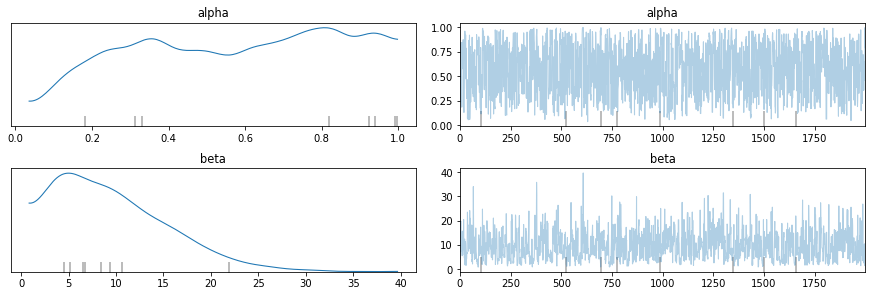

In [15]:
az.plot_trace(tr)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12676b198>,
      dtype=object)

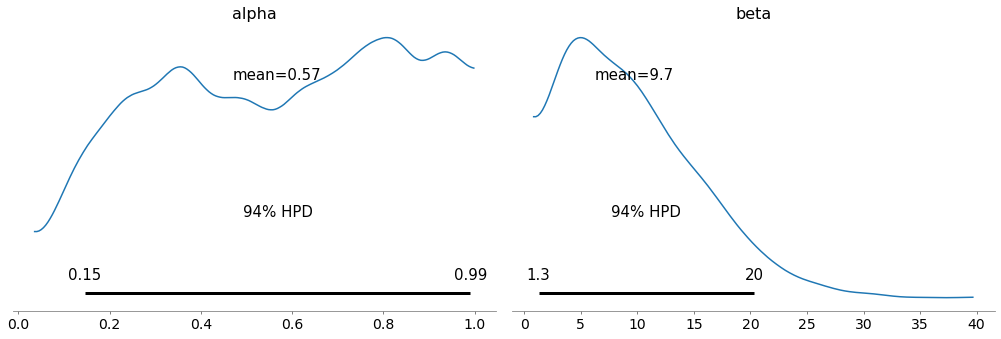

In [16]:
az.plot_posterior(tr)

## MLE vs NUTS for other combinations of $\alpha$ and $\beta$

In [17]:
# Wrap all the steps pre output into a function
def get_mle_nuts_est(true_alpha, true_beta, n=120, mle_niters = 50):

    # Generate data
    machines, actions, rewards, all_Qs = generate_data(true_alpha, true_beta, n)
    true_llik = llik_td_vectorized([true_alpha, true_beta], *(machines, actions, rewards))

    # MLE estimate starting from true value
    x0 = [true_alpha, true_beta]
    result = scipy.optimize.minimize(llik_td_vectorized, x0, args=(machines, actions, rewards), method='BFGS')
    mle_alpha_ts = result.x[0]
    mle_beta_ts = result.x[1]
    mle_llik_ts = result.fun
    
    # MLE estimate starting from value sampled from prior
    print("Starting MLE iterations with random starts...")
    
    mle_iters = pd.DataFrame([])
    for i in range(mle_niters):
        random_alpha_start = np.random.beta(1,1)
        random_beta_start = scipy.stats.halfnorm(scale=10).rvs()
        x0 = [random_alpha_start, random_beta_start]
        result = scipy.optimize.minimize(llik_td_vectorized, x0, args=(machines, actions, rewards), method='BFGS')
        cur_alpha_est = result.x[0]
        cur_beta_est = result.x[1]
        cur_llik = result.fun
        mle_iters = mle_iters.append({"true_alpha": true_alpha,
                                      "true_beta": true_beta,
                                      'random_alpha_start':random_alpha_start,
                                      'random_beta_starts': random_beta_start,
                                      'cur_alpha_est': cur_alpha_est,
                                      'cur_beta_est': cur_beta_est,
                                      'cur_llik': cur_llik}, ignore_index=True)

    print("Done with MLE iterations with random starts.")
    
    mle_alpha_ave = np.mean(mle_iters.cur_alpha_est)
    mle_alpha_std = np.std(mle_iters.cur_alpha_est)
    mle_beta_ave = np.mean(mle_iters.cur_beta_est)
    mle_beta_std = np.std(mle_iters.cur_beta_est)
    mle_llik_ave = np.mean(mle_iters.cur_llik)
    mle_llik_std = np.std(mle_iters.cur_llik)
    
    # NUTS estimate
    actions_ = theano.shared(np.asarray(actions, dtype='int16'))
    with pm.Model() as m:
        alpha = pm.Beta('alpha', 1, 1)
        beta = pm.HalfNormal('beta', 10)
        like = pm.Potential('like', theano_llik_td(alpha, beta, machines, actions, rewards, n))
        tr = pm.sample()
    
    nuts_alpha_ave = np.mean(tr.alpha)
    nuts_beta_ave = np.mean(tr.beta)
    nuts_alpha_std = np.std(tr.alpha)
    nuts_beta_std = np.std(tr.beta)
    nuts_llik = llik_td_vectorized([nuts_alpha_ave, nuts_beta_ave], *(machines, actions, rewards))

    # Output:
    est_df = pd.DataFrame(data={"true_alpha": true_alpha,
                                "true_beta": true_beta,
                                "true_llik": true_llik,
                                "mle_alpha_ts": mle_alpha_ts,
                                "mle_beta_ts": mle_beta_ts,
                                "mle_llik_ts": mle_llik_ts,
                                "mle_alpha_ave":mle_alpha_ave,
                                "mle_beta_ave": mle_beta_ave,
                                "mle_alpha_std":mle_alpha_std,
                                "mle_beta_std": mle_beta_std,
                                "mle_llik_ave": mle_llik_ave,
                                "mle_llik_std":mle_llik_std,
                                "nuts_alpha_ave": nuts_alpha_ave,
                                "nuts_beta_ave": nuts_beta_ave,
                                "nuts_alpha_std": nuts_alpha_std,
                                "nuts_beta_std": nuts_beta_std,
                                "nuts_llik": nuts_llik}, index=[0])
    
    nuts_posteriors = pd.DataFrame(data={"true_alpha": true_alpha,
                                         "true_beta": true_beta,
                                         "alpha": pd.Series(tr.get_values('alpha')),
                                        "beta": pd.Series(tr.get_values('beta'))})
    
    #return {"est_df": est_df, "mle_iters": mle_iters, "nuts_posteriors": nuts_posteriors}
    return (est_df,  mle_iters, nuts_posteriors)

In [ ]:
true_alpha = .65
true_beta = 1.5
est_df, mle_iters, nuts_posteriors = get_mle_nuts_est(true_alpha, true_beta, mle_niters = 10)

In [ ]:
est_df

Next steps:

- ~~Can pyMC recover parameters better for the whole range?~~ 
    - Plot True vs. Estimated plots for MLE vs. NUTS (with credible interval) for full range of combination
        - Two solutions: 
            1. heatmap with different upper and lower triangles. True alpha and beta values on x and y axes and colors denote estimates' deviance from true values for alpha in the upper triangle and beta in the lower triangle
            2. generate fake data and summarise with precision and recall for each combination of estimate
- Data generation functions for different RL models
- Compare parameter recoverability for all RL models 
    - Preferably using only one estimation method having decided which is better from the above MLE vs. NUTS comparison 
- Fit to one subject's data
- Fit to all subjects' data

In [35]:
est_df_merged = pd.read_csv('/Users/zeynepenkavi/Dropbox/PoldrackLab/DevStudy_ServerScripts/fit_rl/pymc3_tests/est_df_merged.csv')

In [41]:
est_df_merged = est_df_merged.sort_values(by=['true_alpha', 'true_beta'])

In [43]:
def triatpos(pos=(0,0), rot=0):
    r = np.array([[-1,-1],[1,-1],[1,1],[-1,-1]])*.5
    rm = [[np.cos(np.deg2rad(rot)), -np.sin(np.deg2rad(rot))],
           [np.sin(np.deg2rad(rot)),np.cos(np.deg2rad(rot)) ] ]
    r = np.dot(rm, r.T).T
    r[:,0] += pos[0]
    r[:,1] += pos[1]
    return r

def triamatrix(a, ax, rot=0, cmap=plt.cm.viridis, **kwargs):
    segs = []
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            segs.append(triatpos((j,i), rot=rot) )
    col = collections.PolyCollection(segs, cmap=cmap, **kwargs)
    col.set_array(a.flatten())
    ax.add_collection(col)
    return col

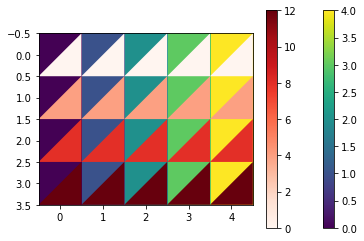

In [44]:
A,B = np.meshgrid(range(5), range(4))
B*=4

fig, ax=plt.subplots()
im1 = ax.imshow(A)
im2 = triamatrix(B, ax, rot=90, cmap="Reds")

fig.colorbar(im1, ax=ax, )
fig.colorbar(im2, ax=ax, )


In [51]:
B

array([[ 0,  0,  0,  0,  0],
       [ 4,  4,  4,  4,  4],
       [ 8,  8,  8,  8,  8],
       [12, 12, 12, 12, 12]])

In [52]:
est_df_merged

,true_alpha,true_beta,true_llik,mle_alpha_ts,mle_beta_ts,mle_llik_ts,mle_alpha_ave,mle_beta_ave,mle_alpha_std,mle_beta_std,mle_llik_ave,mle_llik_std,nuts_alpha_ave,nuts_beta_ave,nuts_alpha_std,nuts_beta_std,nuts_llik
32,0.0,0.0,82.484514,0.000000,0.000000,82.484514,0.153778,3.443438,0.346002,6.296613,82.016096,1.374776e-01,0.223394,0.939461,0.314739,2.956661,2608.257253
33,0.0,0.5,82.484514,-0.214614,0.000941,80.901817,-0.082742,3.114759,0.298651,8.242286,81.022973,1.449242e-01,0.225605,0.780861,0.293657,2.304383,1254.170418
36,0.0,1.0,82.484514,0.000047,10.850000,82.152016,0.034898,9.155347,0.206204,5.413429,82.158576,4.750559e-02,0.173134,0.798419,0.258046,2.164324,795.337541
47,0.0,1.5,82.484514,-0.699464,0.000002,82.138264,0.428150,6.879619,0.768596,7.768027,82.269547,4.525450e-01,0.339027,0.369180,0.325545,1.679270,568.534062
56,0.0,2.0,82.484514,0.000006,1.999966,82.484228,0.220821,6.692522,0.495532,6.617619,82.436247,1.081756e-01,0.167238,0.992112,0.251781,2.646243,1371.727126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,1.0,15.5,6.238325,1.000000,15.500000,6.238325,0.902505,6.953035,0.270895,3.846289,6.238325,6.989411e-07,0.560873,9.183906,0.262650,5.899989,6.238325
462,1.0,16.0,6.238325,1.000000,16.000000,6.238325,0.862982,8.858302,0.316485,4.738208,6.238325,4.970257e-07,0.553987,9.199066,0.258222,5.993878,6.238325
463,1.0,17.0,4.158883,1.000000,17.000000,4.158883,0.885293,7.590516,0.321493,5.035734,4.158884,5.775038e-07,0.563756,9.350585,0.261256,5.953618,4.158883
464,1.0,17.5,5.545177,1.000000,17.500000,5.545177,0.895731,7.469409,0.307233,4.408965,5.545178,4.619267e-07,0.569158,9.154894,0.262225,5.816913,5.545177


In [66]:
df = est_df_merged[["true_alpha", "true_beta", "mle_alpha_ts", "mle_alpha_ave", "nuts_alpha_ave"]]
df = df.melt(id_vars = ["true_alpha", "true_beta"])
df

,true_alpha,true_beta,variable,value
0,0.0,0.0,mle_alpha_ts,0.000000
1,0.0,0.5,mle_alpha_ts,-0.214614
2,0.0,1.0,mle_alpha_ts,0.000047
3,0.0,1.5,mle_alpha_ts,-0.699464
4,0.0,2.0,mle_alpha_ts,0.000006
...,...,...,...,...
1435,1.0,15.5,nuts_alpha_ave,0.560873
1436,1.0,16.0,nuts_alpha_ave,0.553987
1437,1.0,17.0,nuts_alpha_ave,0.563756
1438,1.0,17.5,nuts_alpha_ave,0.569158


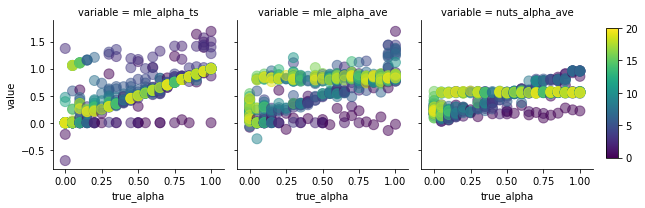

In [73]:
g = sns.FacetGrid(df, col = "variable")

def facet_scatter(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    plt.scatter(x, y, c=c, **kwargs)

vmin, vmax = 0, 20
#cmap = sns.diverging_palette(240, 10, l=65, center="dark", as_cmap=True)

g = g.map(facet_scatter, 'true_alpha', 'value', "true_beta",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)#, cmap=cmap)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)#, cmap=cmap)

# Draw the colorbar
g.fig.colorbar(points, cax=cax)


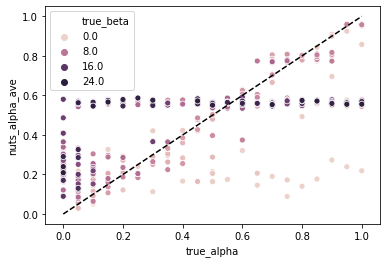

In [57]:
x = np.linspace(0, 1, 100)

sns.scatterplot("true_alpha", "nuts_alpha_ave", hue="true_beta",data=est_df_merged)
plt.plot(x, x, "--",color = "black")

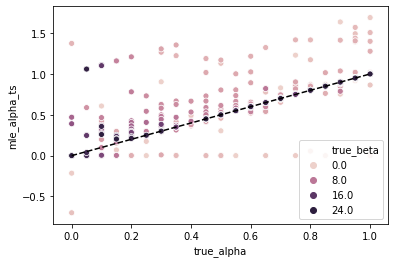

In [58]:
sns.scatterplot("true_alpha", "mle_alpha_ts", hue="true_beta",data=est_df_merged)
plt.plot(x, x, "--",color = "black")

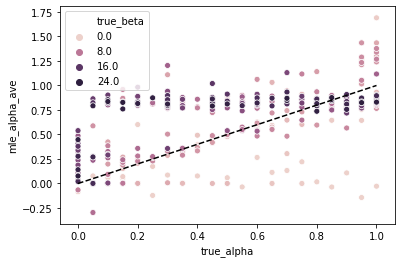

In [59]:
sns.scatterplot("true_alpha", "mle_alpha_ave", hue="true_beta",data=est_df_merged)
plt.plot(x, x, "--",color = "black")

In [ ]:
#Distribution of deviances for alpha
#Color by deviance of beta (instead of true beta)
#Do the same for betas coloring for alphas